<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## **Selected Features: Open, High, Low, Close, Volume**





## A. Checking and Preprocessing

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
from google.colab import files
import pandas as pd

# 讓使用者上傳檔案
uploaded = files.upload()

# 取得上傳檔案的名稱
filename = list(uploaded.keys())[0]

# 讀取檔案
df = pd.read_csv(filename)

# 顯示前幾筆資料確認是否成功讀取
print(df.head())


Saving nvda.us.txt to nvda.us (1).txt
         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-01-22  1.6238  1.8092  1.4379  1.5215  18297633        0
1  1999-01-25  1.6423  1.6980  1.5215  1.6793   3445279        0
2  1999-01-26  1.6980  1.7350  1.5311  1.5494   2320993        0
3  1999-01-27  1.5586  1.5957  1.4660  1.5494   1662658        0
4  1999-01-28  1.5494  1.5586  1.5311  1.5401   1540110        0


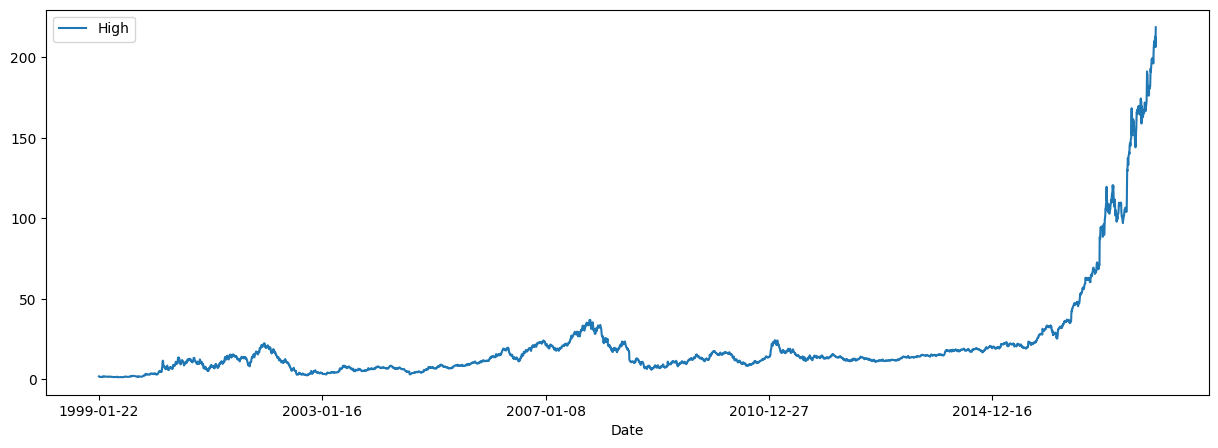

In [75]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [76]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [78]:
# checking for null values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
OpenInt,0


In [79]:
df = df.dropna()

In [80]:
df.shape

(4733, 7)

In [81]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [82]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [83]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [84]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features + log transform Volume
features = df[['Open', 'Close', 'High', 'Low', 'Volume']].copy()
features['Volume'] = np.log(features['Volume'] + 1)  # log transform Volume
labels = df['High'].shift(-1)  # Next day's high price

# Step 2: Normalize features
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Step 3: Create sequences
X, y = create_sequences(features_scaled, labels.values, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# Step 4: Remove NaN samples (shift會有nan)
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# Step 5: Normalize labels (y) separately
label_scaler = MinMaxScaler()
y = label_scaler.fit_transform(y.reshape(-1, 1)).squeeze()

# Step 6: Split hold-out test set
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# Step 7: Shuffle
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]

# Step 8: Train/Val split
split_point = int(X.shape[0]*0.8)
x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Step 9: Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Step 10: Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 5)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 5)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 5)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 5)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


## B. Defining Neural Networks

In [85]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [86]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:50:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             28W /   70W |     344MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import torch.nn as nn
import numpy as np

# 儲存 label scaler 的 min / max（手動處理標準化）
y_min = label_scaler.data_min_[0]
y_max = label_scaler.data_max_[0]

train_losses = []
val_losses = []

epochs = 100
model = LSTMModel(input_dim=5, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3.5e-6)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=2e-6)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)



# 還原用的 inverse function for MinMaxScaler
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

preds = []
trues = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features).squeeze(-1)
        preds.append(outputs.cpu())
        trues.append(labels.cpu())

y_pred_scaled = torch.cat(preds, dim=0)
y_true_scaled = torch.cat(trues, dim=0)

# 還原為原始價格
y_pred_original = inverse_minmax(y_pred_scaled, y_min, y_max)
y_true_original = inverse_minmax(y_true_scaled, y_min, y_max)

# 計算 MSE（在原始價格尺度下）
mse_original = torch.mean((y_true_original - y_pred_original) ** 2).item()
print(f'\n Train MSE on original price scale : {mse_original:.4f}')


LSTMModel(
  (lstm): LSTM(5, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.0285, Val loss: 0.0463, Best Val loss: 0.0463
Epoch 2/100, Train loss: 0.0276, Val loss: 0.0451, Best Val loss: 0.0451
Epoch 3/100, Train loss: 0.0256, Val loss: 0.0439, Best Val loss: 0.0439
Epoch 4/100, Train loss: 0.0247, Val loss: 0.0429, Best Val loss: 0.0429
Epoch 5/100, Train loss: 0.0239, Val loss: 0.0419, Best Val loss: 0.0419
Epoch 6/100, Train loss: 0.0233, Val loss: 0.0409, Best Val loss: 0.0409
Epoch 7/100, Train loss: 0.0237, Val loss: 0.0401, Best Val loss: 0.0401
Epoch 8/100, Train loss: 0.0231, Val loss: 0.0393, Best Val loss: 0.0393
Epoch 9/100, Train loss: 0.0249, Val loss: 0.0385, Best Val loss: 0.0385
Epoch 10/100, Train loss: 0.0215, Val loss: 0.0377, Best Val loss: 0.0377
Epoch 11/100, Train loss: 0.0208, Val loss: 0.0371, Best Val loss: 0.0371
Epoch 12/100, Train loss: 0.0205, Val loss: 0.0365, Best Val loss: 0.0365
Epoch 13/100, Train loss: 0.0198, Val loss: 0.0359, Best Val loss: 0.0359
Epoch 14/100, Train loss: 0.0195, Val loss: 0.0

#### Visualizing the model performance

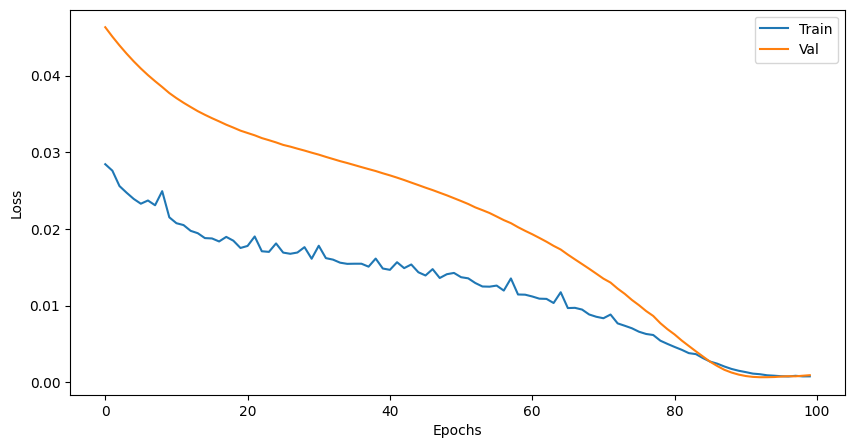

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [89]:
# Step 1: Load the trained model
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

# 還原 MinMaxScaler 的 min/max（你之前標準化 y 使用的）
y_min = label_scaler.data_min_[0]  # label_scaler 是你訓練時使用的 MinMaxScaler
y_max = label_scaler.data_max_[0]

# 還原標準化的 y 值
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # 還原標準化的預測和真實值
        outputs_original = inverse_minmax(outputs, y_min, y_max)
        labels_original = inverse_minmax(labels, y_min, y_max)

        # Calculate the MSE for this batch on the original price scale
        loss = criterion(outputs_original, labels_original)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs_original.cpu())
        actual_value.append(labels_original.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE on original price scale: {average_test_loss:.4f}')


Test MSE on original price scale: 69.2439


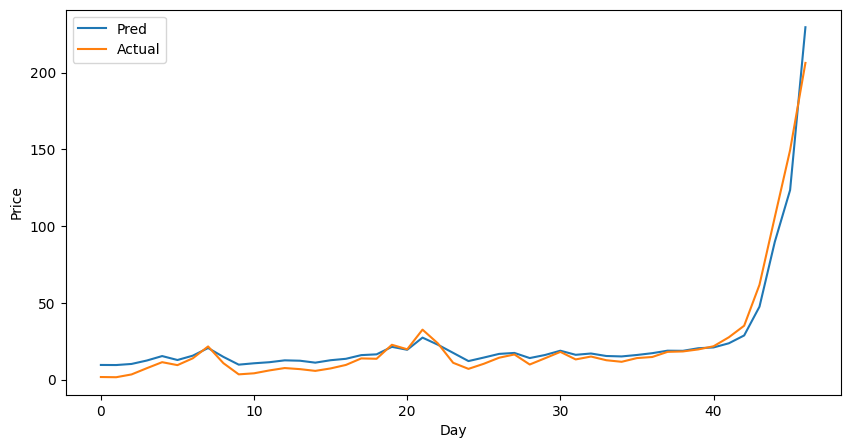

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# **Selected Features: Open, High, Low, Close**

In [91]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [92]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [93]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10, step=15)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


In [94]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [95]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:50:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P0             36W /   70W |     344MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [96]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 893.0971, Val loss: 1384.7209, Best Val loss: 1384.7209
Epoch 2/100, Train loss: 703.5498, Val loss: 1311.9789, Best Val loss: 1311.9789
Epoch 3/100, Train loss: 675.1541, Val loss: 1287.0445, Best Val loss: 1287.0445
Epoch 4/100, Train loss: 772.8256, Val loss: 1271.3462, Best Val loss: 1271.3462
Epoch 5/100, Train loss: 678.0619, Val loss: 1258.8785, Best Val loss: 1258.8785
Epoch 6/100, Train loss: 675.9293, Val loss: 1254.1074, Best Val loss: 1254.1074
Epoch 7/100, Train loss: 674.0987, Val loss: 1172.3545, Best Val loss: 1172.3545
Epoch 8/100, Train loss: 589.0433, Val loss: 1128.8619, Best Val loss: 1128.8619
Epoch 9/100, Train loss: 558.8606, Val loss: 1083.2005, Best Val loss: 1083.2005
Epoch 10/100, Train loss: 531.9726, Val loss: 1031.0235, Best Val loss: 1031.0235
Epoch 11/100, Train loss: 505.7984, Val loss: 976.9455, Best Val loss: 976.9455
Epoch 12/100, Train loss: 473.9372, Val loss: 931.6898, Best Val loss: 931.6898
Epoch 13/100, Train loss: 449

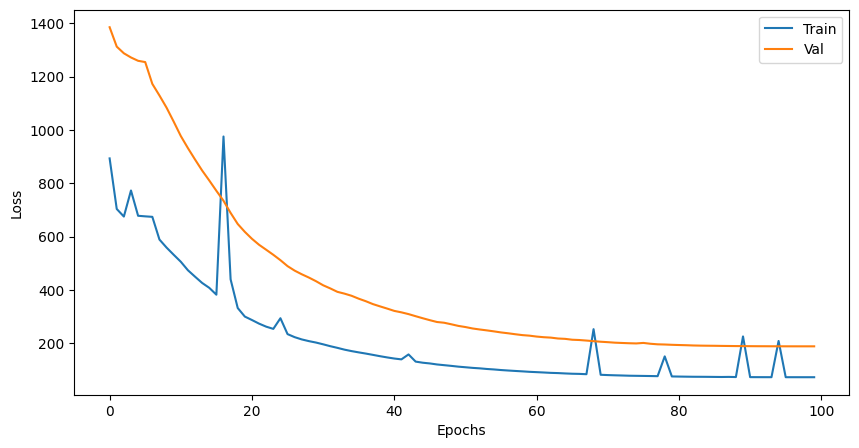

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [98]:
import torch
import torch.nn as nn

# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
test_correct = 0
test_total = 0

pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # Calculate the MSE for this batch
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs.cpu())
        actual_value.append(labels.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE: {average_test_loss:.4f}')

Test MSE: 281.5446


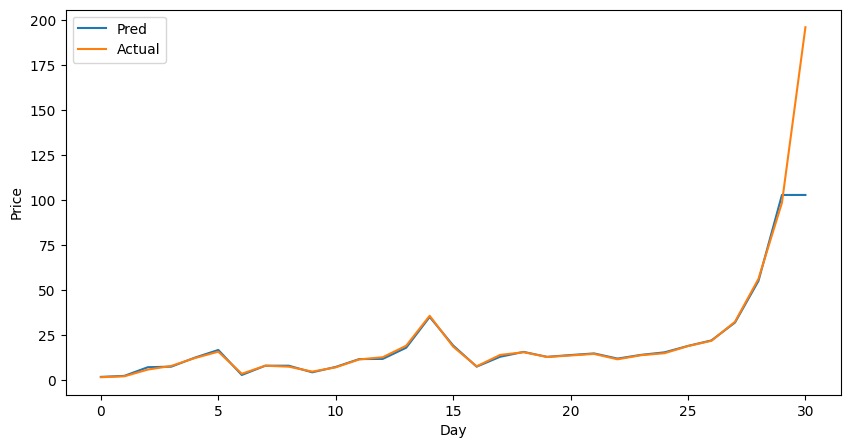

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

## **Selected Features: Open,Close**

In [100]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [101]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [102]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features - now using only 'Open' and 'Close'
features = df[['Open', 'Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 2)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 2)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 2)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 2)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


In [103]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [104]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:50:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             37W /   70W |     344MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [105]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=2, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=9e-4)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(2, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 939.0640, Val loss: 1486.1850, Best Val loss: 1486.1850
Epoch 2/100, Train loss: 813.0199, Val loss: 1425.9257, Best Val loss: 1425.9257
Epoch 3/100, Train loss: 805.7474, Val loss: 1406.4088, Best Val loss: 1406.4088
Epoch 4/100, Train loss: 761.8611, Val loss: 1405.8221, Best Val loss: 1405.8221
Epoch 5/100, Train loss: 757.1478, Val loss: 1405.5815, Best Val loss: 1405.5815
Epoch 6/100, Train loss: 753.1246, Val loss: 1406.6462, Best Val loss: 1405.5815
Epoch 7/100, Train loss: 774.5049, Val loss: 1410.5792, Best Val loss: 1405.5815
Epoch 8/100, Train loss: 751.8990, Val loss: 1406.0501, Best Val loss: 1405.5815
Epoch 9/100, Train loss: 771.5999, Val loss: 1399.7213, Best Val loss: 1399.7213
Epoch 10/100, Train loss: 769.9197, Val loss: 1395.2432, Best Val loss: 1395.2432
Epoch 11/100, Train loss: 768.3255, Val loss: 1390.1970, Best Val loss: 1390.1970
Epoch 12/100, Train loss: 745.2987, Val loss: 1386.9909, Best Val loss: 1386.9909
Epoch 13/100, Train loss:

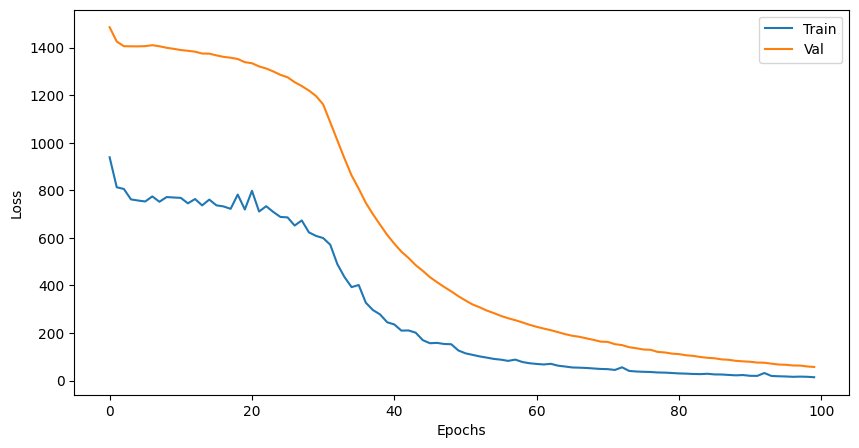

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [107]:
import torch
import torch.nn as nn

# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
test_correct = 0
test_total = 0

pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # Calculate the MSE for this batch
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs.cpu())
        actual_value.append(labels.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE: {average_test_loss:.4f}')

Test MSE: 123.2502


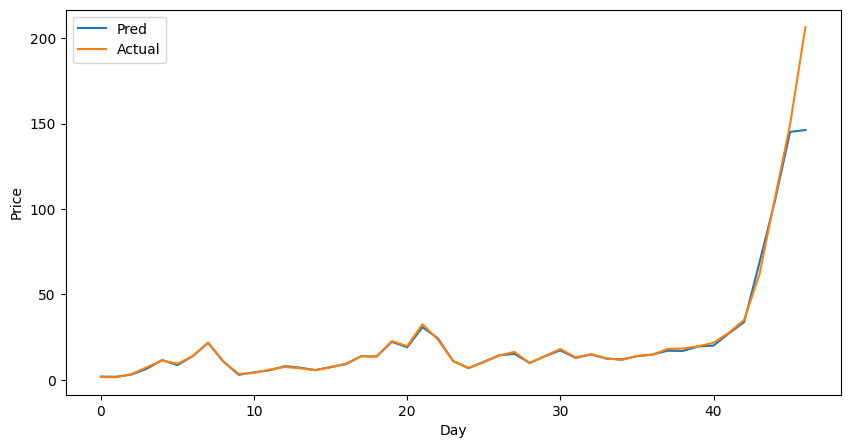

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# **Selected Features: High,Low,Close**

In [109]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [110]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [111]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features - now using only 'Open' and 'Close'
features = df[['High','Low','Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 3)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 3)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 3)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 3)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


In [112]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [113]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:50:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             38W /   70W |     344MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [114]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=3, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=9e-4)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(3, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 941.7650, Val loss: 1505.0526, Best Val loss: 1505.0526
Epoch 2/100, Train loss: 807.5795, Val loss: 1434.3679, Best Val loss: 1434.3679
Epoch 3/100, Train loss: 779.4391, Val loss: 1411.2225, Best Val loss: 1411.2225
Epoch 4/100, Train loss: 774.4515, Val loss: 1406.5577, Best Val loss: 1406.5577
Epoch 5/100, Train loss: 758.8811, Val loss: 1404.9235, Best Val loss: 1404.9235
Epoch 6/100, Train loss: 781.2855, Val loss: 1407.6763, Best Val loss: 1404.9235
Epoch 7/100, Train loss: 753.3357, Val loss: 1404.2373, Best Val loss: 1404.2373
Epoch 8/100, Train loss: 749.9239, Val loss: 1401.5621, Best Val loss: 1401.5621
Epoch 9/100, Train loss: 762.0782, Val loss: 1399.5802, Best Val loss: 1399.5802
Epoch 10/100, Train loss: 760.2899, Val loss: 1394.8875, Best Val loss: 1394.8875
Epoch 11/100, Train loss: 743.8230, Val loss: 1392.8077, Best Val loss: 1392.8077
Epoch 12/100, Train loss: 814.8712, Val loss: 1394.5819, Best Val loss: 1392.8077
Epoch 13/100, Train loss:

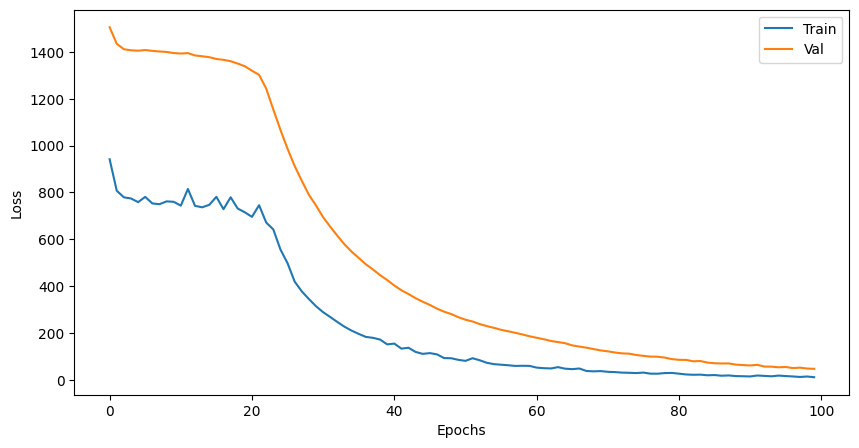

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [116]:
import torch
import torch.nn as nn

# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
test_correct = 0
test_total = 0

pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # Calculate the MSE for this batch
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs.cpu())
        actual_value.append(labels.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE: {average_test_loss:.4f}')

Test MSE: 106.8861


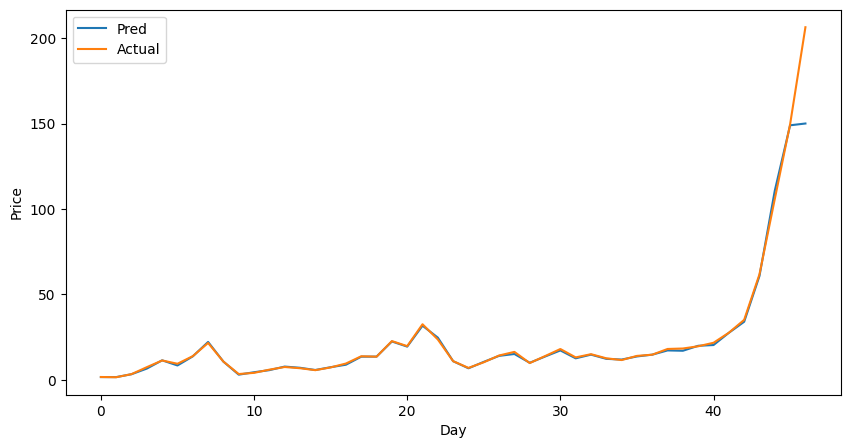

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# **Selected Features: Open,Close,Volume**

In [118]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [119]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)


In [120]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features + log transform Volume
features = df[['Open', 'Close', 'Volume']].copy()  # Now using 'Open', 'Close', and 'Volume'
features['Volume'] = np.log(features['Volume'] + 1)  # log transform Volume
labels = df['High'].shift(-1)  # Next day's high price

# Step 2: Normalize features
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Step 3: Create sequences
X, y = create_sequences(features_scaled, labels.values, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# Step 4: Remove NaN samples (shift會有nan)
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# 🛠️ Step 5: Normalize labels (y) separately
label_scaler = MinMaxScaler()
y = label_scaler.fit_transform(y.reshape(-1, 1)).squeeze()

# Step 6: Split hold-out test set
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# Step 7: Shuffle
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]

# Step 8: Train/Val split
split_point = int(X.shape[0]*0.8)
x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Step 9: Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Step 10: Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 3)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 3)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 3)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 3)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


In [121]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [122]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:50:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             39W /   70W |     344MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [123]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import torch.nn as nn
import numpy as np

# 儲存 label scaler 的 min / max（手動處理標準化還原）
y_min = label_scaler.data_min_[0]
y_max = label_scaler.data_max_[0]

train_losses = []
val_losses = []

epochs = 100
model = LSTMModel(input_dim=3, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5.5e-6)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=3e-6)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


# 還原用的 inverse function for MinMaxScaler
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

# 載入最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

preds = []
trues = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features).squeeze(-1)
        preds.append(outputs.cpu())
        trues.append(labels.cpu())

y_pred_scaled = torch.cat(preds, dim=0)
y_true_scaled = torch.cat(trues, dim=0)

# 還原為原始價格
y_pred_original = inverse_minmax(y_pred_scaled, y_min, y_max)
y_true_original = inverse_minmax(y_true_scaled, y_min, y_max)

# 計算 MSE（在原始價格尺度下）
mse_original = torch.mean((y_true_original - y_pred_original) ** 2).item()
print(f'\n Train MSE on original price scale : {mse_original:.4f}')


LSTMModel(
  (lstm): LSTM(3, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.0380, Val loss: 0.0569, Best Val loss: 0.0569
Epoch 2/100, Train loss: 0.0365, Val loss: 0.0545, Best Val loss: 0.0545
Epoch 3/100, Train loss: 0.0344, Val loss: 0.0524, Best Val loss: 0.0524
Epoch 4/100, Train loss: 0.0325, Val loss: 0.0503, Best Val loss: 0.0503
Epoch 5/100, Train loss: 0.0303, Val loss: 0.0484, Best Val loss: 0.0484
Epoch 6/100, Train loss: 0.0296, Val loss: 0.0467, Best Val loss: 0.0467
Epoch 7/100, Train loss: 0.0271, Val loss: 0.0450, Best Val loss: 0.0450
Epoch 8/100, Train loss: 0.0256, Val loss: 0.0434, Best Val loss: 0.0434
Epoch 9/100, Train loss: 0.0249, Val loss: 0.0419, Best Val loss: 0.0419
Epoch 10/100, Train loss: 0.0237, Val loss: 0.0405, Best Val loss: 0.0405
Epoch 11/100, Train loss: 0.0222, Val loss: 0.0393, Best Val loss: 0.0393
Epoch 12/100, Train loss: 0.0233, Val loss: 0.0382, Best Val loss: 0.0382
Epoch 13/100, Train loss: 0.0206, Val loss: 0.0371, Best Val loss: 0.0371
Epoch 14/100, Train loss: 0.0198, Val loss: 0.0

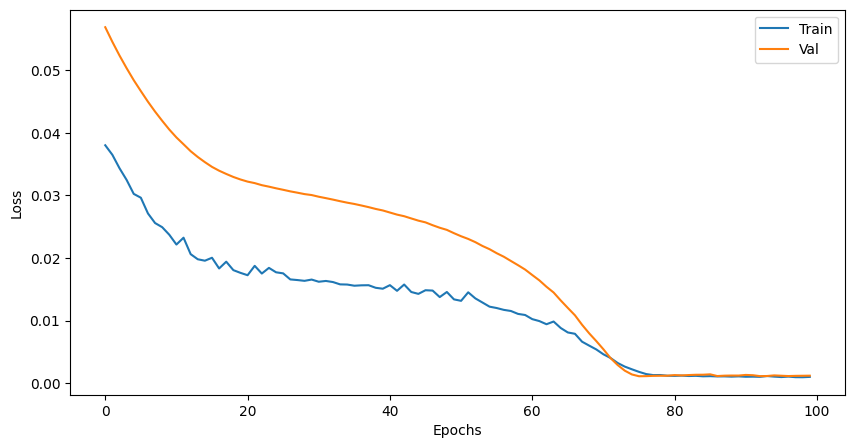

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [125]:
# Step 1: Load the trained model
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

# 還原 MinMaxScaler 的 min/max（你之前標準化 y 使用的）
y_min = label_scaler.data_min_[0]  # label_scaler 是你訓練時使用的 MinMaxScaler
y_max = label_scaler.data_max_[0]

# 還原標準化的 y 值
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # 還原標準化的預測和真實值
        outputs_original = inverse_minmax(outputs, y_min, y_max)
        labels_original = inverse_minmax(labels, y_min, y_max)

        # Calculate the MSE for this batch on the original price scale
        loss = criterion(outputs_original, labels_original)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs_original.cpu())
        actual_value.append(labels_original.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE on original price scale: {average_test_loss:.4f}')


Test MSE on original price scale: 113.5097


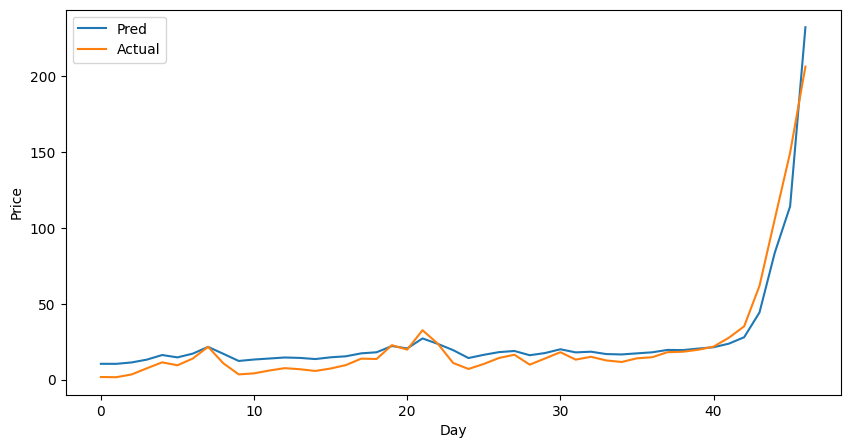

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# **Selected Features: Close,High,Low,Volume**

In [127]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [128]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [129]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features + log transform Volume
features = df[['High', 'Low', 'Close', 'Volume']].copy()
features['Volume'] = np.log(features['Volume'] + 1)  # log transform Volume
labels = df['High'].shift(-1)  # Next day's high price

# Step 2: Normalize features
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Step 3: Create sequences
X, y = create_sequences(features_scaled, labels.values, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# Step 4: Remove NaN samples (shift會有nan)
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# Step 5: Normalize labels (y) separately
label_scaler = MinMaxScaler()
y = label_scaler.fit_transform(y.reshape(-1, 1)).squeeze()

# Step 6: Split hold-out test set
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# Step 7: Shuffle
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]

# Step 8: Train/Val split
split_point = int(X.shape[0]*0.8)
x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Step 9: Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Step 10: Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 4)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 4)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 4)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 4)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


In [130]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [131]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:51:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             39W /   70W |     344MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [132]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import torch.nn as nn
import numpy as np

# 儲存 label scaler 的 min / max（手動處理標準化還原）
y_min = label_scaler.data_min_[0]
y_max = label_scaler.data_max_[0]

train_losses = []
val_losses = []

epochs = 100
model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


# 還原用的 inverse function for MinMaxScaler
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

# 載入最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

preds = []
trues = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features).squeeze(-1)
        preds.append(outputs.cpu())
        trues.append(labels.cpu())

y_pred_scaled = torch.cat(preds, dim=0)
y_true_scaled = torch.cat(trues, dim=0)

# 還原為原始價格
y_pred_original = inverse_minmax(y_pred_scaled, y_min, y_max)
y_true_original = inverse_minmax(y_true_scaled, y_min, y_max)

# 計算 MSE（在原始價格尺度下）
mse_original = torch.mean((y_true_original - y_pred_original) ** 2).item()
print(f'\n Train MSE on original price scale : {mse_original:.4f}')


LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.0293, Val loss: 0.0461, Best Val loss: 0.0461
Epoch 2/100, Train loss: 0.0264, Val loss: 0.0444, Best Val loss: 0.0444
Epoch 3/100, Train loss: 0.0250, Val loss: 0.0429, Best Val loss: 0.0429
Epoch 4/100, Train loss: 0.0238, Val loss: 0.0415, Best Val loss: 0.0415
Epoch 5/100, Train loss: 0.0228, Val loss: 0.0402, Best Val loss: 0.0402
Epoch 6/100, Train loss: 0.0220, Val loss: 0.0391, Best Val loss: 0.0391
Epoch 7/100, Train loss: 0.0211, Val loss: 0.0381, Best Val loss: 0.0381
Epoch 8/100, Train loss: 0.0216, Val loss: 0.0372, Best Val loss: 0.0372
Epoch 9/100, Train loss: 0.0198, Val loss: 0.0364, Best Val loss: 0.0364
Epoch 10/100, Train loss: 0.0201, Val loss: 0.0357, Best Val loss: 0.0357
Epoch 11/100, Train loss: 0.0202, Val loss: 0.0350, Best Val loss: 0.0350
Epoch 12/100, Train loss: 0.0199, Val loss: 0.0345, Best Val loss: 0.0345
Epoch 13/100, Train loss: 0.0196, Val loss: 0.0339, Best Val loss: 0.0339
Epoch 14/100, Train loss: 0.0206, Val loss: 0.0

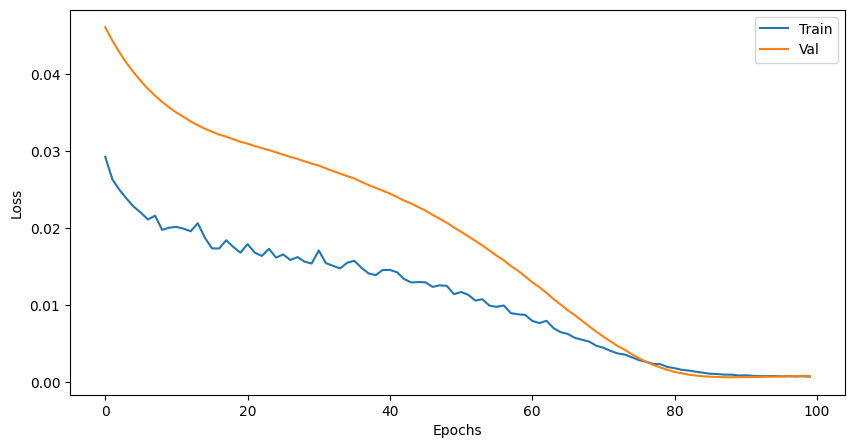

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [134]:
# Step 1: Load the trained model
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

# 還原 MinMaxScaler 的 min/max（你之前標準化 y 使用的）
y_min = label_scaler.data_min_[0]  # label_scaler 是你訓練時使用的 MinMaxScaler
y_max = label_scaler.data_max_[0]

# 還原標準化的 y 值
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # 還原標準化的預測和真實值
        outputs_original = inverse_minmax(outputs, y_min, y_max)
        labels_original = inverse_minmax(labels, y_min, y_max)

        # Calculate the MSE for this batch on the original price scale
        loss = criterion(outputs_original, labels_original)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs_original.cpu())
        actual_value.append(labels_original.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE on original price scale: {average_test_loss:.4f}')


Test MSE on original price scale: 69.0354


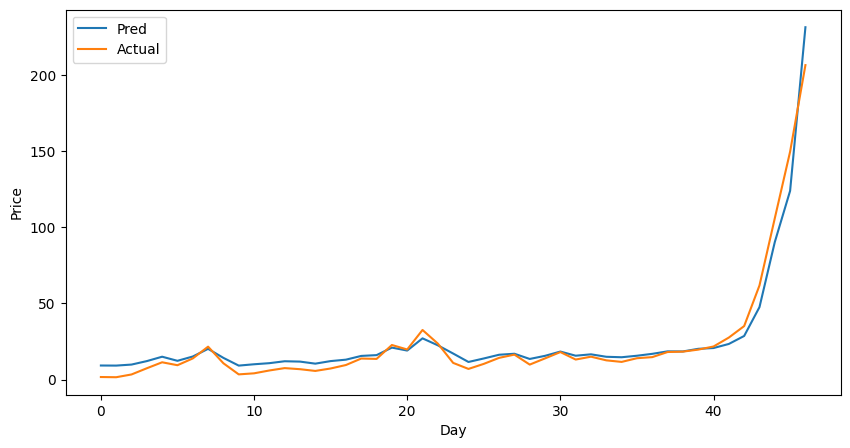

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# **Selected Features: Close,Volume**

In [136]:
import numpy as np
import torch

seed = 42

# 固定 NumPy 的隨機種子
np.random.seed(seed)

# 固定 PyTorch 的隨機種子
torch.manual_seed(seed)  # 設定 CPU 隨機種子
torch.cuda.manual_seed(seed)  # 設定單張 GPU 隨機種子
torch.cuda.manual_seed_all(seed)  # 設定所有 GPU 隨機種子（如果有多張）

# 讓 CuDNN 的計算保持確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [137]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [138]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features + log transform Volume
features = df[['Close', 'Volume']].copy()
features['Volume'] = np.log(features['Volume'] + 1)  # log transform Volume
labels = df['High'].shift(-1)  # Next day's high price

# Step 2: Normalize features
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Step 3: Create sequences
X, y = create_sequences(features_scaled, labels.values, window_size=30, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# Step 4: Remove NaN samples (shift會有nan)
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# Step 5: Normalize labels (y) separately
label_scaler = MinMaxScaler()
y = label_scaler.fit_transform(y.reshape(-1, 1)).squeeze()

# Step 6: Split hold-out test set
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# Step 7: Shuffle
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]

# Step 8: Train/Val split
split_point = int(X.shape[0]*0.8)
x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Step 9: Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Step 10: Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')


Shape of data X: (471, 30, 2)
Shape of data y: (471,)
Shape of data x_train: (339, 30, 2)
Shape of data y_train: (339,)
Shape of data x_val: (85, 30, 2)
Shape of data y_val: (85,)
Shape of data x_test: (47, 30, 2)
Shape of data y_test: (47,)
Number of samples in training and validation are 339 and 85.


In [139]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [140]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 12:51:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             40W /   70W |     344MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [141]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import torch.nn as nn
import numpy as np

# 儲存 label scaler 的 min / max（手動處理標準化還原）
y_min = label_scaler.data_min_[0]
y_max = label_scaler.data_max_[0]

train_losses = []
val_losses = []

epochs = 100
model = LSTMModel(input_dim=2, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=4.8e-6)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=2e-6)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


# 還原用的 inverse function for MinMaxScaler
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

# 載入最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

preds = []
trues = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features).squeeze(-1)
        preds.append(outputs.cpu())
        trues.append(labels.cpu())

y_pred_scaled = torch.cat(preds, dim=0)
y_true_scaled = torch.cat(trues, dim=0)

# 還原為原始價格
y_pred_original = inverse_minmax(y_pred_scaled, y_min, y_max)
y_true_original = inverse_minmax(y_true_scaled, y_min, y_max)

# 計算 MSE（在原始價格尺度下）
mse_original = torch.mean((y_true_original - y_pred_original) ** 2).item()
print(f'\n Train MSE on original price scale : {mse_original:.4f}')


LSTMModel(
  (lstm): LSTM(2, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.0231, Val loss: 0.0399, Best Val loss: 0.0399
Epoch 2/100, Train loss: 0.0229, Val loss: 0.0387, Best Val loss: 0.0387
Epoch 3/100, Train loss: 0.0222, Val loss: 0.0377, Best Val loss: 0.0377
Epoch 4/100, Train loss: 0.0203, Val loss: 0.0368, Best Val loss: 0.0368
Epoch 5/100, Train loss: 0.0196, Val loss: 0.0360, Best Val loss: 0.0360
Epoch 6/100, Train loss: 0.0191, Val loss: 0.0354, Best Val loss: 0.0354
Epoch 7/100, Train loss: 0.0192, Val loss: 0.0349, Best Val loss: 0.0349
Epoch 8/100, Train loss: 0.0184, Val loss: 0.0344, Best Val loss: 0.0344
Epoch 9/100, Train loss: 0.0187, Val loss: 0.0340, Best Val loss: 0.0340
Epoch 10/100, Train loss: 0.0186, Val loss: 0.0336, Best Val loss: 0.0336
Epoch 11/100, Train loss: 0.0184, Val loss: 0.0334, Best Val loss: 0.0334
Epoch 12/100, Train loss: 0.0178, Val loss: 0.0331, Best Val loss: 0.0331
Epoch 13/100, Train loss: 0.0182, Val loss: 0.0329, Best Val loss: 0.0329
Epoch 14/100, Train loss: 0.0176, Val loss: 0.0

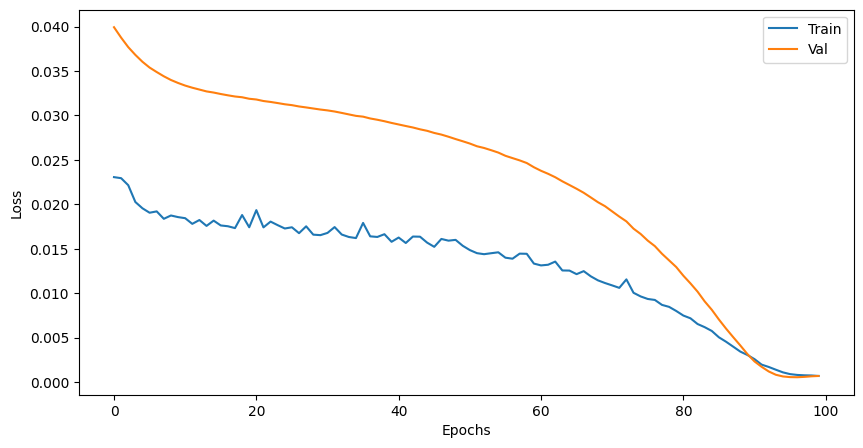

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

In [143]:
# Step 1: Load the trained model
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for testing
pred_value = []
actual_value = []

# Initialize MSE loss function
criterion = nn.MSELoss()

# Initialize variable to accumulate the MSE loss
total_test_loss = 0

# 還原 MinMaxScaler 的 min/max（你之前標準化 y 使用的）
y_min = label_scaler.data_min_[0]  # label_scaler 是你訓練時使用的 MinMaxScaler
y_max = label_scaler.data_max_[0]

# 還原標準化的 y 值
def inverse_minmax(tensor, data_min, data_max):
    return tensor * (data_max - data_min) + data_min

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()

        # Forward pass: compute predicted values
        outputs = model(features).squeeze(-1)

        # 還原標準化的預測和真實值
        outputs_original = inverse_minmax(outputs, y_min, y_max)
        labels_original = inverse_minmax(labels, y_min, y_max)

        # Calculate the MSE for this batch on the original price scale
        loss = criterion(outputs_original, labels_original)
        total_test_loss += loss.item()

        # Store predictions and actual values
        pred_value.append(outputs_original.cpu())
        actual_value.append(labels_original.cpu())

# Concatenate all predictions and actual values
pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

# Calculate the average MSE for the entire test set
average_test_loss = total_test_loss / len(test_loader)
print(f'Test MSE on original price scale: {average_test_loss:.4f}')


Test MSE on original price scale: 72.7786


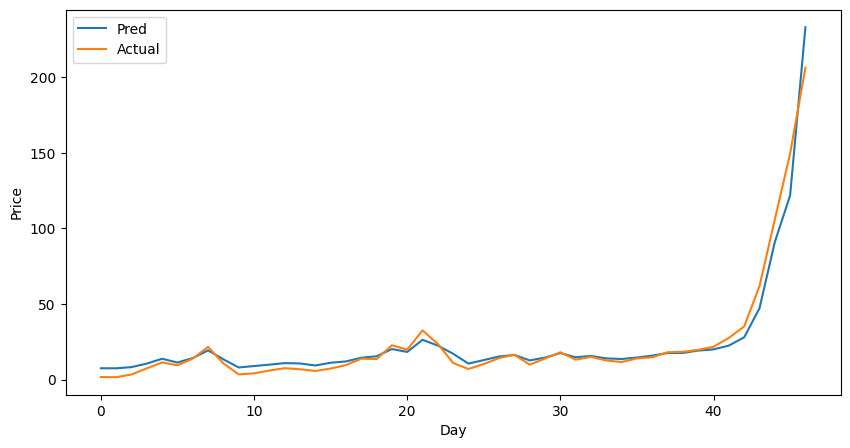

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()